Shape of dataset: (178, 14)

Data types:
 Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
Customer_Segment          int64
dtype: object

Missing values:
 Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
Customer_Segment        0
dtype: int64

Summary statistics:
           Alcohol  Malic_Acid         Ash  Ash_Alcanity   Magnesium  \
count  1

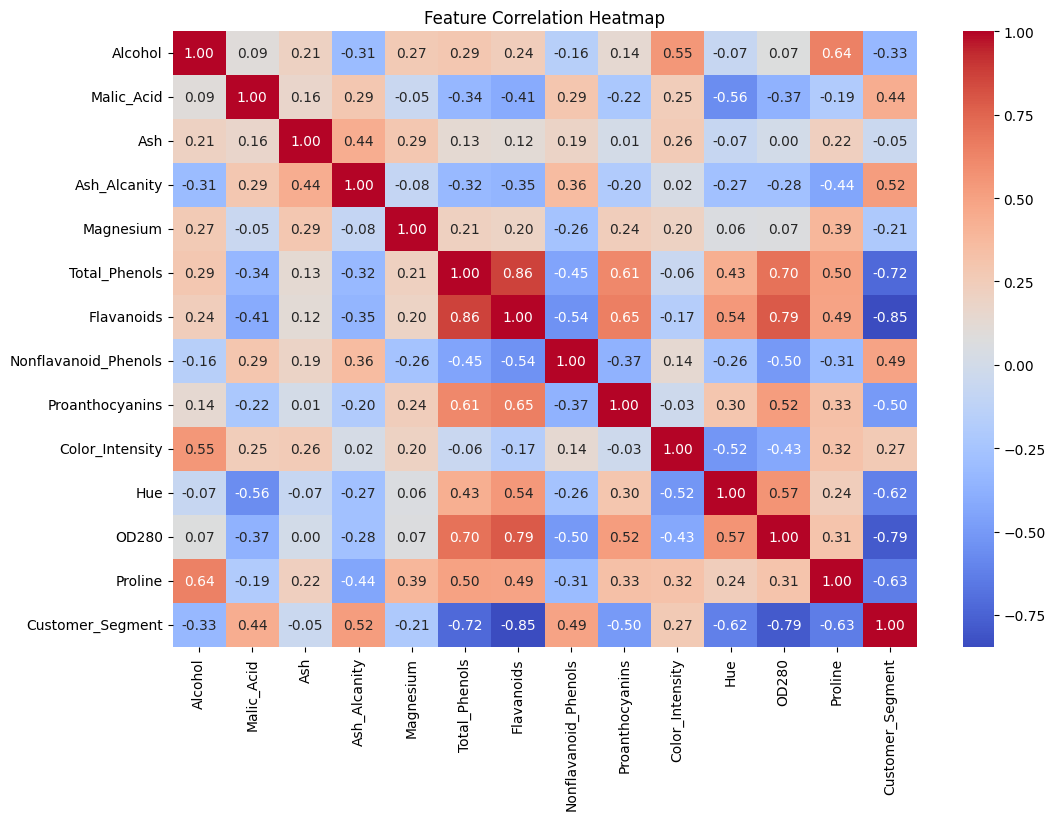

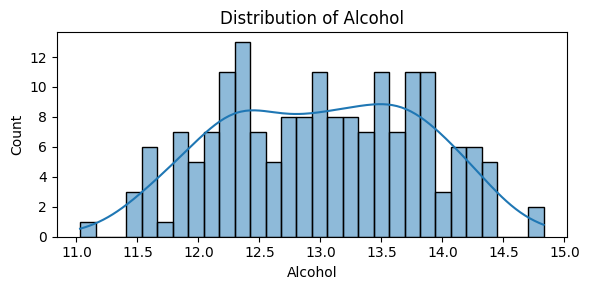

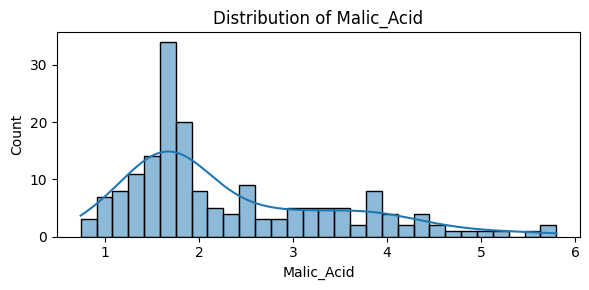

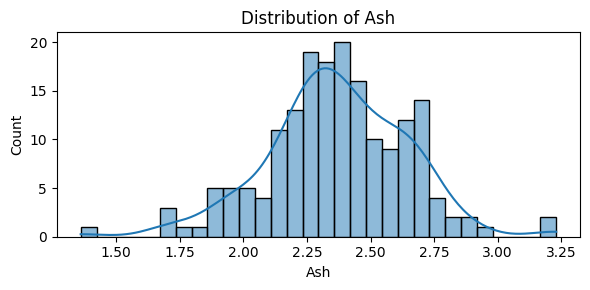

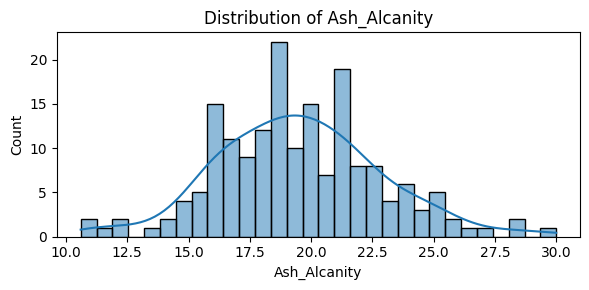

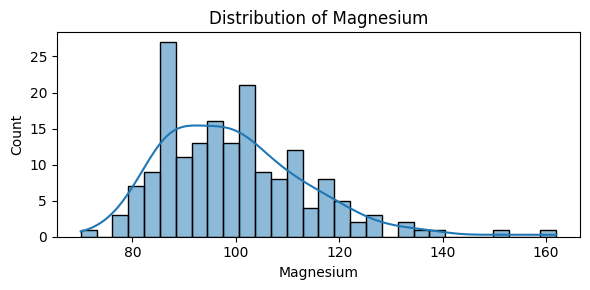

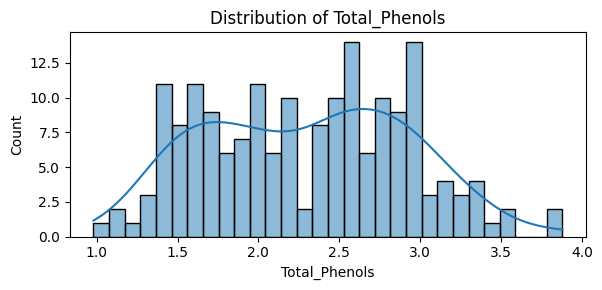

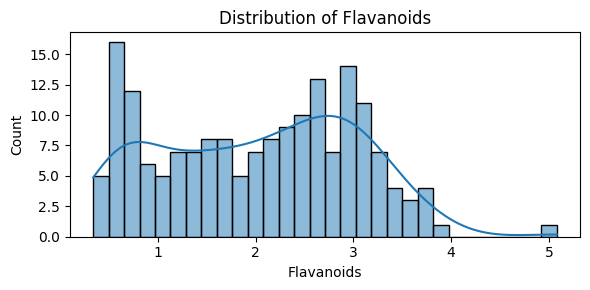

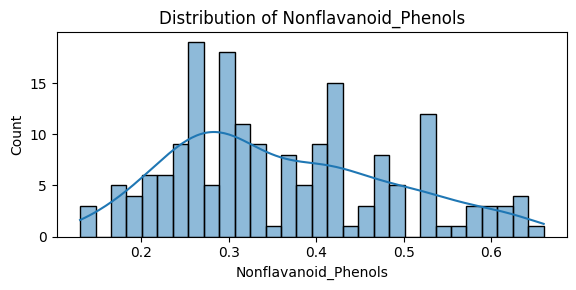

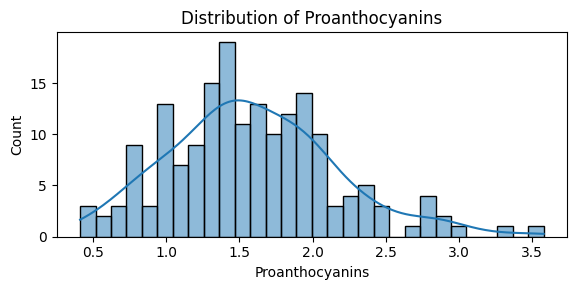

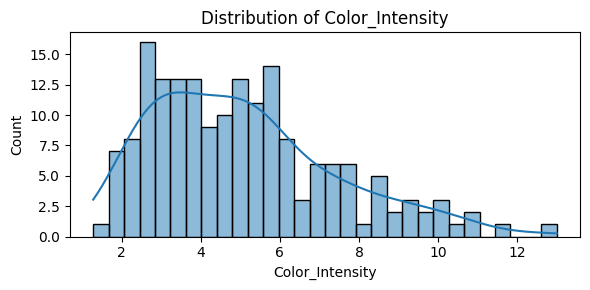

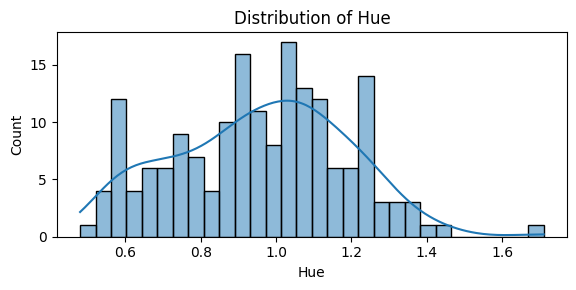

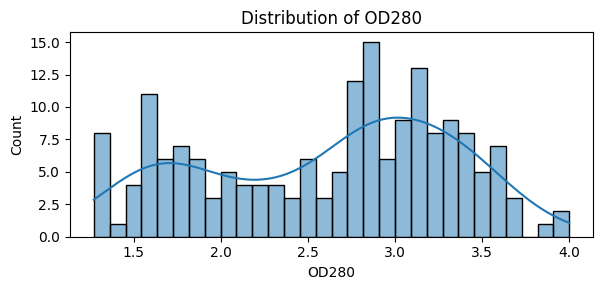

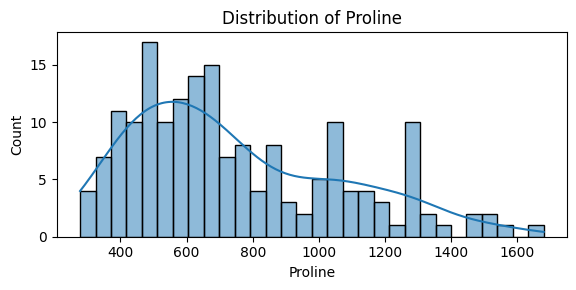

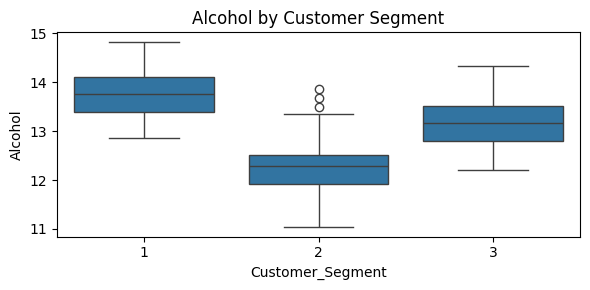

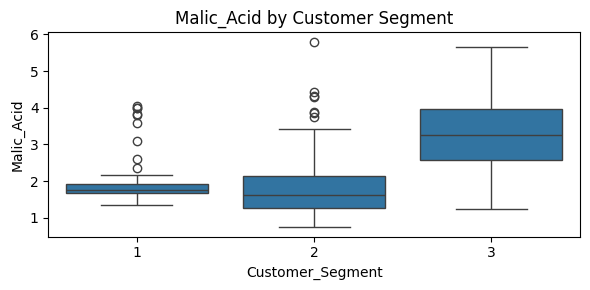

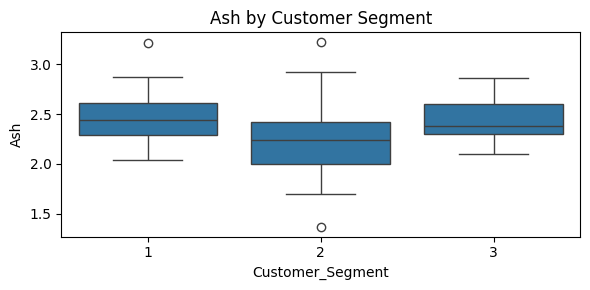

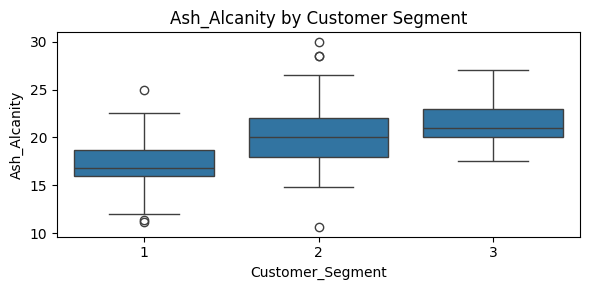

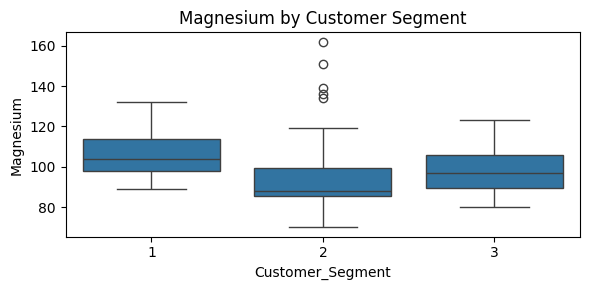

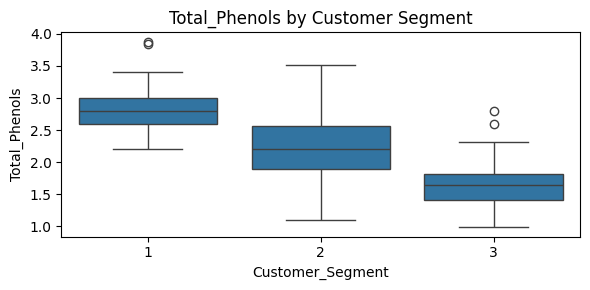

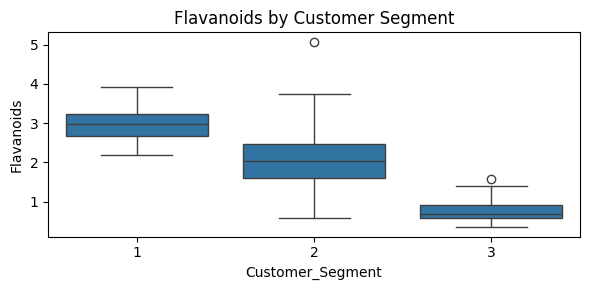

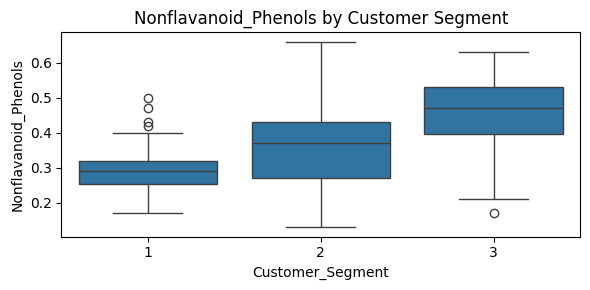

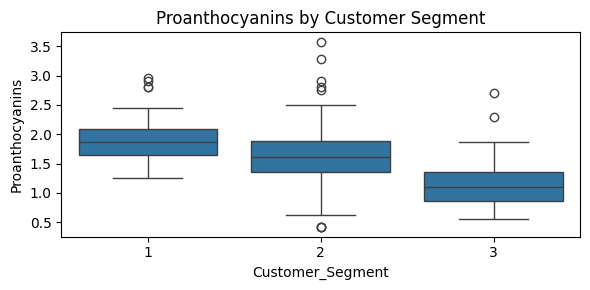

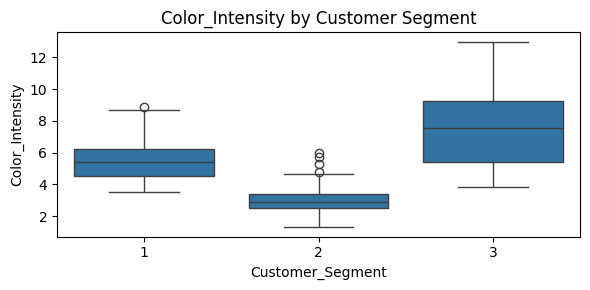

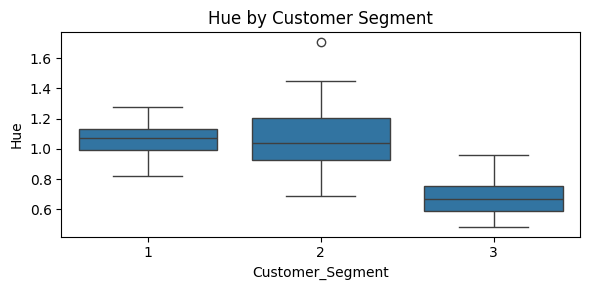

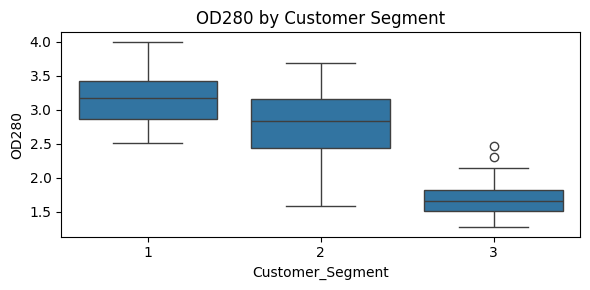

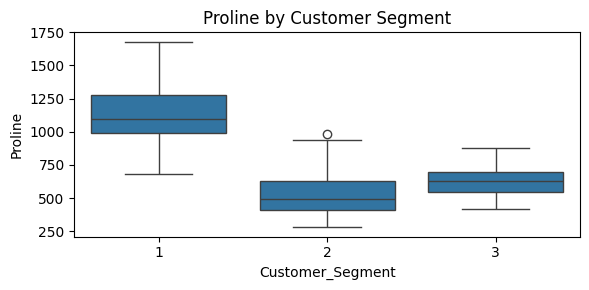

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Wine.csv")

# Basic info
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary statistics:\n", df.describe())

# Class distribution
print("\nCustomer Segment distribution:\n", df['Customer_Segment'].value_counts())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Distribution plots
features = df.columns[:-1]  # exclude 'Customer_Segment'

for col in features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# Boxplots by Customer Segment
for col in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x='Customer_Segment', y=col)
    plt.title(f"{col} by Customer Segment")
    plt.tight_layout()
    plt.show()

-Silhouette score ranges from -1 to 1; higher = tighter clusters, better separation.

-Adjusted Rand Index (ARI): Measures how well the clustering matches the true labels


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Separate features and target
X = df.drop(columns=["Customer_Segment"])
y_true = df["Customer_Segment"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define clustering models
models = {
    "KMeans (k=3)": KMeans(n_clusters=3, random_state=42),
    "Agglomerative (k=3)": AgglomerativeClustering(n_clusters=3),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5)
}

# Evaluate clustering
results = []
for name, model in models.items():
    try:
        labels = model.fit_predict(X_scaled)
        sil_score = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        ari = adjusted_rand_score(y_true, labels)
        results.append({
            "Model": name,
            "Silhouette Score": round(sil_score, 3),
            "Davies-Bouldin Score": round(db_score, 3),
            "Adjusted Rand Index (Accuracy)": round(ari, 3)
        })
    except Exception as e:
        results.append({
            "Model": name,
            "Silhouette Score": None,
            "Davies-Bouldin Score": None,
            "Adjusted Rand Index (Accuracy)": None,
            "Error": str(e)
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Silhouette Score  Davies-Bouldin Score  \
0         KMeans (k=3)             0.285                 1.389   
1  Agglomerative (k=3)             0.277                 1.419   
2               DBSCAN               NaN                   NaN   

   Adjusted Rand Index (Accuracy)  \
0                           0.897   
1                           0.790   
2                             NaN   

                                               Error  
0                                                NaN  
1                                                NaN  
2  Number of labels is 1. Valid values are 2 to n...  


Using PCA to see if results can be improved

In [15]:
from sklearn.decomposition import PCA

# PCA to reduce the number of features while keeping 95% of the data’s variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Evaluate clustering
results = []
for name, model in models.items():
    try:
        labels = model.fit_predict(X_pca)
        sil_score = silhouette_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        ari = adjusted_rand_score(y_true, labels)
        results.append({
            "Model": name,
            "Silhouette Score": round(sil_score, 3),
            "Davies-Bouldin Score": round(db_score, 3),
            "Adjusted Rand Index (Accuracy)": round(ari, 3)
        })
    except Exception as e:
        results.append({
            "Model": name,
            "Silhouette Score": None,
            "Davies-Bouldin Score": None,
            "Adjusted Rand Index (Accuracy)": None,
            "Error": str(e)
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Silhouette Score  Davies-Bouldin Score  \
0         KMeans (k=3)             0.299                 1.336   
1  Agglomerative (k=3)             0.284                 1.344   
2               DBSCAN            -0.272                 1.556   

   Adjusted Rand Index (Accuracy)  
0                           0.897  
1                           0.759  
2                           0.012  


KMeans gave the best result, but I wanted to see if I could improve the results even more.

So I decided to use PCA and try GaussianMixture and compare it with KMeans

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score


# Try KMeans again
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Try Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# 4. Evaluation
print("KMeans ARI:", adjusted_rand_score(y_true, kmeans_labels))
print("GMM ARI:", adjusted_rand_score(y_true, gmm_labels))
print("KMeans Silhouette:", silhouette_score(X_pca, kmeans_labels))
print("GMM Silhouette:", silhouette_score(X_pca, gmm_labels))


KMeans ARI: 0.8974949815093207
GMM ARI: 0.9650516223023584
KMeans Silhouette: 0.29867482943692886
GMM Silhouette: 0.293740702660551


Based on the results, both has a similar Silhoutte score, but GMM has a better ARI.

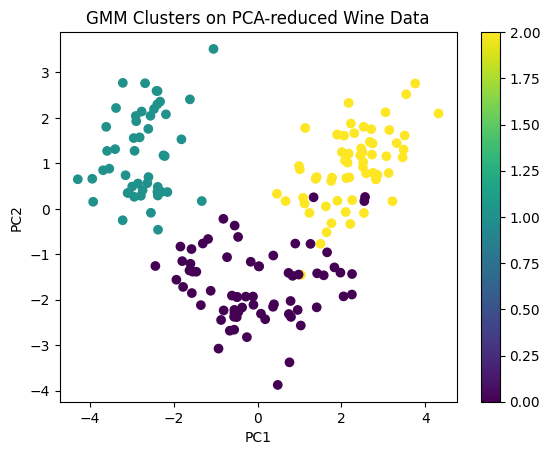

In [17]:
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title("GMM Clusters on PCA-reduced Wine Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()
